In [1]:
import cv2
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from aijack.attack import GradientInversion_Attack
from aijack.utils import NumpyDataset

In [2]:
class LeNet(nn.Module):
    def __init__(self, channel=3, hideen=768, num_classes=10):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            nn.BatchNorm2d(12),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            nn.BatchNorm2d(12),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            nn.BatchNorm2d(12),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(hideen, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.shape)
        out = self.fc(out)
        return out

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor()
                                ])

train_dataset = torchvision.datasets.CIFAR10(
            root="/home/featurize/data",
            train=True,
            download=True,
            transform=transform
        )

tp = transforms.ToPILImage()

data_dl = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=0)

Files already downloaded and verified


In [4]:
torch.manual_seed(1)

shape_img = (32, 32)
num_classes = 10
channel = 3
hidden = 768

device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"

for data in data_dl:
    x, y = data[0], data[1]
    break

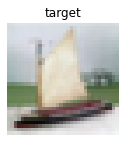

  0%|          | 0/1 [00:00<?, ?it/s]

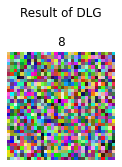

In [9]:
plt.figure(figsize=(2, 4))
plt.imshow(tp(x[:1][0]))
plt.axis("off")
plt.title("target")
plt.show()

criterion = nn.CrossEntropyLoss()
net = LeNet(channel=channel, hideen=hidden, num_classes=num_classes).to(device)
x = x.to(device)
y = y.to(device)
pred = net(x[:1])
loss = criterion(pred, y[:1])
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]

dlg_attacker = GradientInversion_Attack(net, (3, 32, 32), lr=1.0, log_interval=10,
                                    num_iteration=500,
                                    distancename="l2",
                                    device=device)

num_seeds=1
fig = plt.figure()
for s in tqdm(range(num_seeds)):
    dlg_attacker.reset_seed(s)
    result = dlg_attacker.attack(received_gradients)
    ax1 = fig.add_subplot(2, num_seeds, s+1)
    ax1.imshow(tp(result[0][0]))
    ax1.set_title(torch.argmax(result[1]).item())
    ax1.axis("off")
    # ax2 = fig.add_subplot(2, num_seeds, num_seeds+s+1)
    # ax2.imshow(cv2.medianBlur(result[0].detach().numpy()[0][0], 5), cmap="gray")
    # ax2.axis("off")
plt.suptitle("Result of DLG")
plt.tight_layout()
plt.show()

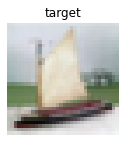

  0%|          | 0/1 [00:00<?, ?it/s]

iter=10: 18.288681030273438, (best_iter=10: 18.288681030273438)
iter=20: 17.199369430541992, (best_iter=20: 17.199369430541992)
iter=30: 16.169275283813477, (best_iter=30: 16.169275283813477)
iter=40: 15.205638885498047, (best_iter=40: 15.205638885498047)
iter=50: 14.308629989624023, (best_iter=50: 14.308629989624023)
iter=60: 13.480005264282227, (best_iter=60: 13.480005264282227)
iter=70: 12.716819763183594, (best_iter=70: 12.716819763183594)
iter=80: 12.01920223236084, (best_iter=80: 12.01920223236084)
iter=90: 11.378509521484375, (best_iter=90: 11.378509521484375)
iter=100: 10.793293952941895, (best_iter=100: 10.793293952941895)
iter=110: 10.256586074829102, (best_iter=110: 10.256586074829102)
iter=120: 9.765469551086426, (best_iter=120: 9.765469551086426)
iter=130: 9.31278133392334, (best_iter=130: 9.31278133392334)
iter=140: 8.899104118347168, (best_iter=140: 8.899104118347168)
iter=150: 8.517982482910156, (best_iter=150: 8.517982482910156)
iter=160: 8.164710998535156, (best_iter=

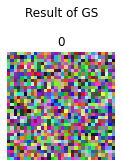

In [28]:
batch_size = 3

plt.figure(figsize=(2, 4))
plt.imshow(tp(x[:1][0]))
plt.axis("off")
plt.title("target")
plt.show()

criterion = nn.CrossEntropyLoss()
net = LeNet(channel=channel, hideen=hidden, num_classes=num_classes).to(device)
x = x.to(device)
y = y.to(device)
pred = net(x[:1])
loss = criterion(pred, y[:1])
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]

gs_attacker = GradientInversion_Attack(net, (3, 32, 32), 
                                    lr=10e2, 
                                    log_interval=10,
                                    optimizer_class=torch.optim.SGD,
                                    num_iteration=10000,
                                    distancename="l2",
                                    optimize_label=False,
                                    lm_reg_coef=0.01,
                                    device=device)

num_seeds=1
fig = plt.figure()
for s in tqdm(range(num_seeds)):
    gs_attacker.reset_seed(s)
    result = gs_attacker.attack(received_gradients)
    ax1 = fig.add_subplot(2, num_seeds, s+1)
    ax1.axis("off")
    # ax1.imshow(result[0].detach().numpy()[0][0], cmap="gray")
    ax1.imshow(tp(result[0][0]))
    ax1.set_title(torch.argmax(result[1]).item())
    # ax2 = fig.add_subplot(2, num_seeds, num_seeds+s+1)
    # ax2.imshow(cv2.medianBlur(result[0].detach().numpy()[0][0], 5), cmap="gray")
    # ax2.axis("off")
plt.suptitle("Result of GS")
plt.tight_layout()
plt.show()

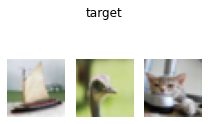

worker_id=0: iter=100: 0.5721765160560608, (best_iter=100: 0.5721765160560608)
worker_id=1: iter=100: 0.5555316209793091, (best_iter=100: 0.5555316209793091)
worker_id=2: iter=100: 0.5587021112442017, (best_iter=100: 0.5587021112442017)
worker_id=3: iter=100: 0.5698547959327698, (best_iter=100: 0.5698547959327698)
worker_id=4: iter=100: 0.5813185572624207, (best_iter=100: 0.5813185572624207)
worker_id=0: iter=200: 0.2789596915245056, (best_iter=200: 0.2789596915245056)
worker_id=1: iter=200: 0.2701466679573059, (best_iter=200: 0.2701466679573059)
worker_id=2: iter=200: 0.26067018508911133, (best_iter=200: 0.26067018508911133)
worker_id=3: iter=200: 0.27208805084228516, (best_iter=200: 0.27208805084228516)
worker_id=4: iter=200: 0.27650919556617737, (best_iter=200: 0.27650919556617737)
worker_id=0: iter=300: 0.18183301389217377, (best_iter=300: 0.18183301389217377)
worker_id=1: iter=300: 0.17464546859264374, (best_iter=300: 0.17464546859264374)
worker_id=2: iter=300: 0.16708150506019592

Text(0.5, 0.98, 'Result of GradInversion')

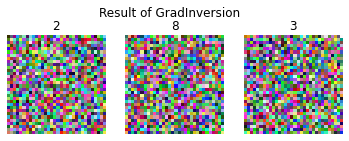

In [25]:
batch_size = 3




fig = plt.figure(figsize=(3, 2))
for bi in range(batch_size):
    ax = fig.add_subplot(1, batch_size, bi+1)
    ax.imshow(tp(x[bi]))
    ax.axis("off")
plt.suptitle("target")
plt.tight_layout()
plt.show()

criterion = nn.CrossEntropyLoss()

net = LeNet(channel=channel, hideen=hidden, num_classes=num_classes).to(device)
x = x.to(device)
y = y.to(device)

pred = net(x[:batch_size])
loss = criterion(pred, y[:batch_size])
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]

gradinversion = GradientInversion_Attack(net, (3, 32, 32), num_iteration=5000,
                                    lr=15, log_interval=100,
                                    optimizer_class=torch.optim.SGD,
                                    distancename="l2", optimize_label=False,
                                    bn_reg_layers=[net.body[1], net.body[4], net.body[7]],
                                    group_num = 5,
                                    tv_reg_coef=0.00, l2_reg_coef=0.0001,
                                    bn_reg_coef=0.001, gc_reg_coef=0.001,
                                    device=device)

result = gradinversion.group_attack(received_gradients, batch_size=batch_size)

fig = plt.figure()
for bid in range(batch_size):
    ax1 = fig.add_subplot(2, batch_size, bid+1)
    ax1.imshow(tp((sum(result[0]) / len(result[0]))[bid]))
    ax1.axis("off")
    ax1.set_title(result[1][0][bid].item())
    # ax2 = fig.add_subplot(2, batch_size, batch_size+bid+1)
    # ax2.imshow(cv2.medianBlur((sum(result[0]) / len(result[0])).detach().numpy()[bid][0], 3), cmap="gray")
    # ax2.axis("off")

plt.suptitle("Result of GradInversion")